<a href="https://colab.research.google.com/github/jytan023/SUSS-Projects/blob/main/Final-Year-Project/ANL488_Python_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANL488 - Optimization Model for Nurse Scheduling with PYOMO

This notebook uses PYOMO and COIN-CBC with Python to perform Nurse Scheduling. This notebook contains the entire process of doing the scheduling optimization model, constructing the optimization model using PYOMO, and finally obtain the optimized schedule. 


>This notebook requires either the installation of Jupyter Notebook or the use of Google Colab. The code is mainly written using Google Colab, but could be used for Jupyter Notebook as well, although certain codes need to be re-written to ensure that everything will run smoothly. 


## Installing and Importing Packages

The following code will install and import various Python and Pyomo packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

#Import packages for data manipulation
import sys
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  
import datetime as dt
import matplotlib.pyplot as plt

# Installing Pyomo and Coin CBC Solver
!pip install -q pyomo 
!apt-get install -y -qq coinor-cbc
!apt-get install -y -qq glpk-utils

# import the necessary packages from PYOMO
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt.results import SolverStatus, TerminationCondition

import pyomo.environ as pyo
infinity = float('inf')

from pyomo.contrib.sensitivity_toolbox.sens import sipopt



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 9.5MB 3.4MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 256kB 44.8MB/s 
     |████████████████████████████████| 163kB 53.2MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting pre

### INPUT: Nurse Rostering Benchmark Instances

We will be using "Nurse Rostering Benchmark Instances" dataset to conduct the optimization. In the folder, there is a ".txt" format and a ".xml" format. We will use the ".txt" file and conduct some data understanding and manipulate the data into a usable format. 

## Import data and data manipulation


Add the datafile into google drive under the following directory, or change the directory to where the file is located.


In [ ]:
X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Instance3.txt', sep="\t", header = None)

dct = {}
for i in range(0, len(X)):
  if 'SECTION' in X.iat[i, 0]:
    j = 2
    colnames = X.iat[i+1, 0].lstrip('# ')
    colnames = list(colnames.split(', '))
    k = pd.DataFrame(columns=colnames)
    while 'SECTION' not in X.iat[i+j, 0]:
      val = list(X.iat[i+j,0].split(','))
      if len(val) > len(k.columns):
        k[j] = []
        colnames.append(j)
        print(k, colnames)
      l = pd.DataFrame(np.array([val]), columns=colnames)
      k = k.append(l,ignore_index=True)
      j = j+1
      if i+j == len(X):
        break

    dct[X.iat[i, 0]] = k

# Example of one of the table
print(dct['SECTION_STAFF'].to_markdown())

|    | ID   | MaxShifts     |   MaxTotalMinutes |   MinTotalMinutes |   MaxConsecutiveShifts |   MinConsecutiveShifts |   MinConsecutiveDaysOff |   MaxWeekends |
|---:|:-----|:--------------|------------------:|------------------:|-----------------------:|-----------------------:|------------------------:|--------------:|
|  0 | A    | E=14|D=14|L=0 |              4320 |              3360 |                      5 |                      2 |                       2 |             1 |
|  1 | B    | E=14|D=14|L=5 |              4320 |              3360 |                      5 |                      2 |                       2 |             1 |
|  2 | C    | E=14|D=14|L=5 |              4320 |              3360 |                      5 |                      2 |                       2 |             1 |
|  3 | D    | E=14|D=0|L=5  |              4320 |              3360 |                      5 |                      2 |                       2 |             1 |
|  4 | E    | E=14|D=0|L=0  

## Set up the MILP Model

### Defining Sets, Parameters, Variables, Objective and Constraints

In [ ]:
# Model
model = pyo.AbstractModel()

# Sets
# Nurses
model.N = Set()
# Days
model.D = Set()
# Shifts
model.S = Set()
# Weekends
model.W = Set()
# To generate Constraint
model.no_mincs_para = Set()
model.no_mincd_para = Set()

# Total days 
model.days = Param(within =PositiveIntegers)

# Parameters
# maximum number of shifts of type s that can be assigned to nurse n.
model.maxs = Param(model.N, model.S, within=NonNegativeReals)
# minimum and maximum number of minutes that nurse n must be assigned.
model.minmin = Param(model.N, within=NonNegativeReals)
model.maxmin = Param(model.N, within=NonNegativeReals)
# minimum and maximum number of consecutive shifts that nurse n must work. .
model.mincs = Param(model.N, within=NonNegativeReals)
model.maxcs = Param(model.N, within=NonNegativeReals)
# minimum number of consecutive days off that nurse n can be assigned.
model.mincd = Param(model.N, within=NonNegativeReals)
# maximum number of weekends that nurse n can work.
model.maxwe = Param(model.N, within=PositiveReals)

# penalty if shift type s is not assigned to nurse n on day d.
model.pnot = Param(model.N, model.D, model.S, default = 0)
# penalty if shift type s is assigned to nurse n on day d.
model.pyes = Param(model.N, model.D, model.S, default = 0)
# preferred total number of nurses assigned shift type s on day d.
model.schreq = Param(model.D, model.S, default = 0)
# weight if below the preferred cover for shift type s on day d. 
model.underreq = Param(model.D, model.S, default = 0)
# weight if exceeding the preferred cover for shift type s on day d. 
model.overreq = Param(model.D, model.S, default = 0)
# cannot work in following shift the next day
model.shiftfollow = Param(model.S, model.S, default = 2)

# time for shift s
model.shifttime = Param(model.S, within=NonNegativeReals)
# nurse n off days
model.day_off = Param(model.N, model.D, default = 0)

# empty constraint to set constraints after solving
model.c = pyo.ConstraintList()


In [ ]:
#Variables

model.w = Var(model.N, model.W, domain = Binary)
model.x = Var(model.N, model.D, model.S, within=Binary)
model.y = Var(model.D, model.S, within = NonNegativeReals)
model.z = Var(model.D, model.S, within = NonNegativeReals)

In [ ]:
#Objective

# Minimize the cost of this schedule
def cost_rule(model):
    return (sum(model.pnot[i,j,k]*(1-model.x[i,j,k]) for i in model.N for j in model.D for k in model.S) 
    + sum(model.pyes[i,j,k]*model.x[i,j,k] for i in model.N for j in model.D for k in model.S) 
    + sum(model.underreq[j,k]*model.y[j,k] for j in model.D for k in model.S) 
    + sum(model.overreq[j,k]*model.z[j,k]for j in model.D for k in model.S))


model.cost = Objective(rule = cost_rule, sense = minimize)

In [ ]:
#Constraints
# only 1 shift for each day.
def one_shift_day_rule(model, i, j):
    value = sum(model.x[i,j,k] for k in model.S)
    return value <= 1
model.one_shift_day_con = Constraint(model.N, model.D, rule = one_shift_day_rule)

# maximum number of shift that can be taken by that employee
def max_shift_rule(model, i, k):
    return sum(model.x[i,j,k] for j in model.D) <= value(model.maxs[i,k])
model.max_shift_rule_con = Constraint(model.N, model.S, rule = max_shift_rule)

# Total working time rule
def working_time_rule(model, i):
    value = sum(model.shifttime[k]*model.x[i,j,k] for j in model.D for k in model.S)
    # return model.minmin[i] <= value <= model.maxmin[i]
    return inequality(model.minmin[i],value,model.maxmin[i])
model.working_time_rule_con = Constraint(model.N, rule = working_time_rule)

# max consecutive day rule
def max_con_day_rule(model, i, j):
    if j >= value(model.days)- value(model.maxcs[i]):
      return Constraint.Skip
    return sum(model.x[i,j+l,k] for l in range(0,model.maxcs[i]+1) for k in model.S) <= model.maxcs[i]
model.max_con_day_rule_con = Constraint(model.N, model.D, rule = max_con_day_rule)

# min consecutive day rule
def min_con_day_rule(model, i, j, n):
    if j >= value(model.days)-n-1 or n >=model.mincs[i]:
      return Constraint.Skip
    return (sum(model.x[i,j+l,k] for k in model.S for l in [0,n+1]) - sum(model.x[i,j+l,k] for l in range(1,n+1) for k in model.S)) >= (1-n)
model.min_con_day_rule_con = Constraint(model.N, model.D, model.no_mincs_para, rule = min_con_day_rule)

# min consecutive day off rule
def min_con_day_off_rule(model, i, j, n):
    if j >= value(model.days)-n-1 or n >=model.mincd[i]:
      return Constraint.Skip
    return (sum(model.x[i,j+l,k] for k in model.S for l in [0,n+1]) - sum(model.x[i,j+l,k] for l in range(1,n+1) for k in model.S)) <= 1
model.min_con_day_off_rule_con = Constraint(model.N, model.D, model.no_mincd_para, rule = min_con_day_off_rule)

# Constraint to determine if a nurse has worked on a particular week
def week_rule(model, i, j, h):
    if (j+1)%7 != 0:
      return Constraint.Skip
    if (j+1)//7 -1 != h:
      return Constraint.Skip
    return  sum(model.x[i,j,k] + model.x[i,(j-1),k] for k in model.S)  - 2*model.w[i, h] <= 0
model.week_rule_con = Constraint(model.N, model.D, model.W , rule = week_rule)

def week2_rule(model, i, j, h):
    if (j+1)%7 != 0:
      return Constraint.Skip
    if (j+1)//7-1 != h:
      return Constraint.Skip
    return   sum(model.x[i,j,k] + model.x[i,(j-1),k] for k in model.S) - model.w[i, h]>= 0
model.week2_rule_con = Constraint(model.N, model.D, model.W , rule = week2_rule)

# Max number of weekends
def max_weekend_rule(model, i):
    return (sum(model.w[i,h] for h in model.W) <= model.maxwe[i])
model.max_weekend_rule_con = Constraint(model.N, rule = max_weekend_rule)

# Days off rule
def days_off_rule(model, i, j):
    if value(model.day_off[i,j]) == 0:
      return Constraint.Skip
    return sum(model.x[i,j,k] for k in model.S) == 0
model.days_off_rule_con = Constraint(model.N, model.D, rule = days_off_rule)

# Schedule Requirement rule
def req_rule(model, j, k):
    return sum(model.x[i,j,k] for i in model.N) - model.z[j,k] + model.y[j,k] == model.schreq[j,k]
model.req_rule_con = Constraint(model.D, model.S, rule = req_rule)

# Cannot work in following shift rule
def following_rule(model, i, j, k, g):
    if model.shiftfollow[k,g] != 1 or j ==(model.days-1):
      return Constraint.Skip
    return model.x[i,j,k] + model.x[i,j+1,g]  <= model.shiftfollow[k,g]
model.following_con = Constraint(model.N, model.D, model.S, model.S, rule = following_rule)


### Format Data to add values into Abstract Model

In [ ]:
# Data
all_nurse = list(dct['SECTION_STAFF']['ID'])
all_day = list(range(int(dct['SECTION_HORIZON'].iloc[1,0])))
all_shift = list(dct['SECTION_SHIFTS']['ShiftID'])
total_day = int(dct['SECTION_HORIZON'].iloc[1,0])
weeks = list(range((total_day+1)//7)) #in the event when time period ends on saturday


maxs = dct['SECTION_STAFF'].iloc[:,[0,1]] 
colname = ['ID']
maxshift=maxs['MaxShifts'].str.split('|', expand = True)
maxs = pd.concat([maxs.iloc[:,0], maxshift], axis=1)
for i in maxs.columns:
  if i != 'ID':
    maxshift = maxs.loc[:,i].str.split('=', expand=True)
    maxs[i] = maxshift.loc[:,1].astype(int)
    maxs.rename(columns={i:maxshift.iloc[0,0] }, inplace = True)
    colname.append(maxshift.iloc[0,0])
maxs = maxs.melt(id_vars=['ID'], var_name='ShiftID', value_name='maxs')
maxs = maxs.set_index(['ID', 'ShiftID'])
maxs = maxs.to_dict()

minmin = dct['SECTION_STAFF'].iloc[:,[0,3]]
minmin.iloc[:,1] = minmin.iloc[:,1].astype(int)
minmin = minmin.set_index(['ID'])
minmin = minmin.to_dict()

maxmin = dct['SECTION_STAFF'].iloc[:,[0,2]]
maxmin.iloc[:,1] = maxmin.iloc[:,1].astype(int)
maxmin = maxmin.set_index(['ID'])
maxmin = maxmin.to_dict()

mincs = dct['SECTION_STAFF'].iloc[:,[0,5]]
mincs.iloc[:,1] = mincs.iloc[:,1].astype(int)
mincs = mincs.set_index(['ID'])
min_day = max(mincs['MinConsecutiveShifts'])
no_mincs_con = list(range(1, min_day))
mincs = mincs.to_dict()

maxcs = dct['SECTION_STAFF'].iloc[:,[0,4]]
maxcs.iloc[:,1] = maxcs.iloc[:,1].astype(int)
maxcs = maxcs.set_index(['ID'])
maxcs = maxcs.to_dict()

mincd = dct['SECTION_STAFF'].iloc[:,[0,6]]
mincd.iloc[:,1] = mincd.iloc[:,1].astype(int)
mincd = mincd.set_index(['ID'])
min_off = max(mincd['MinConsecutiveDaysOff'])
no_mincd_con = list(range(1,min_off))
mincd = mincd.to_dict()

maxwe = dct['SECTION_STAFF'].iloc[:,[0,7]]
maxwe.iloc[:,1] = maxwe.iloc[:,1].astype(int)
maxwe = maxwe.set_index(['ID'])
maxwe = maxwe.to_dict()

pnot = dct['SECTION_SHIFT_ON_REQUESTS']
pnot.iloc[:,[1,3]] = pnot.iloc[:,[1,3]].astype(int)
pnot = pnot.set_index(['EmployeeID', 'Day', 'ShiftID'])
pnot = pnot.to_dict()

pyes = dct['SECTION_SHIFT_OFF_REQUESTS']
pyes.iloc[:,[1,3]] = pyes.iloc[:,[1,3]].astype(int)
pyes = pyes.set_index(['EmployeeID', 'Day', 'ShiftID'])
pyes = pyes.to_dict()

schreq = dct['SECTION_COVER'].iloc[:,[0,1,2]]
schreq.iloc[:,[0,2]] = schreq.iloc[:,[0,2]].astype(int)
schreq = schreq.set_index(['Day', 'ShiftID'])
schreq = schreq.to_dict()

underreq = dct['SECTION_COVER'].iloc[:,[0,1,3]]
underreq.iloc[:,[0,2]] = underreq.iloc[:,[0,2]].astype(int)
underreq = underreq.set_index(['Day', 'ShiftID'])
underreq = underreq.to_dict()

overreq = dct['SECTION_COVER'].iloc[:,[0,1,4]]
overreq.iloc[:,[0,2]] = overreq.iloc[:,[0,2]].astype(int)
overreq = overreq.set_index(['Day', 'ShiftID'])
overreq = overreq.to_dict()

shifttime = dct['SECTION_SHIFTS'].iloc[:,[0,1]]
shifttime.iloc[:,1] = shifttime.iloc[:,1].astype(int)
shifttime = shifttime.set_index(['ShiftID'])
shifttime = shifttime.to_dict()

shiftfollow = dct['SECTION_SHIFTS'].iloc[:,[0,2]]
follow = shiftfollow['Shifts which cannot follow this shift | separated'].str.split('|', expand = True)
shiftfollow = pd.concat([shiftfollow.iloc[:,0], follow], axis=1)
shiftfollow = shiftfollow.melt(id_vars=['ShiftID'], var_name='shiftfollow', value_name='shift2')
shiftfollow.replace('', np.nan, inplace=True)
shiftfollow.dropna(subset=['shift2'], inplace=True)
shiftfollow['shiftfollow'] = 1
shiftfollow = shiftfollow.set_index(['ShiftID', 'shift2'])
shiftfollow = shiftfollow.to_dict()

day_off = dct['SECTION_DAYS_OFF'].iloc[:,:].copy()
day_off.iloc[:, day_off.columns!= 'EmployeeID'] = day_off.iloc[:,day_off.columns!= 'EmployeeID'].astype(int)
day_off = pd.melt(day_off, id_vars='EmployeeID',value_vars=list(day_off.columns.difference({'EmployeeID'})))
day_off['Off'] = 1
day_off = day_off.set_index(['EmployeeID', 'value'])
day_off = day_off.drop(columns=['variable'])
day_off = day_off.to_dict()


In [ ]:
# Feed into Pyomo
data = {None: {
    'N': {None: all_nurse},
    'D': {None: all_day},
    'S': {None: all_shift},
    'W': {None: weeks},
    'days' : {None: total_day},
    'no_mincs_para' : {None: no_mincs_con},
    'no_mincd_para' : {None: no_mincd_con}
}}

data[None]['maxs'] = maxs['maxs']
data[None]['minmin'] = minmin['MinTotalMinutes']
data[None]['maxmin'] = maxmin['MaxTotalMinutes']
data[None]['mincs'] = mincs['MinConsecutiveShifts']
data[None]['maxcs'] = maxcs['MaxConsecutiveShifts']
data[None]['mincd'] = mincd['MinConsecutiveDaysOff']
data[None]['maxwe'] = maxwe['MaxWeekends']
data[None]['pnot'] = pnot['Weight']
data[None]['pyes'] = pyes['Weight']
data[None]['schreq'] = schreq['Requirement']
data[None]['underreq'] = underreq['Weight for under']
data[None]['overreq'] = overreq['Weight for over']
data[None]['shifttime'] = shifttime['Length in mins']
data[None]['day_off'] = day_off['Off']
data[None]['shiftfollow'] = shiftfollow['shiftfollow']

print(data)

{None: {'N': {None: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']}, 'D': {None: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}, 'S': {None: ['E', 'D', 'L']}, 'W': {None: [0, 1]}, 'days': {None: 14}, 'no_mincs_para': {None: [1]}, 'no_mincd_para': {None: [1, 2]}, 'maxs': {('A', 'E'): 14, ('B', 'E'): 14, ('C', 'E'): 14, ('D', 'E'): 14, ('E', 'E'): 14, ('F', 'E'): 14, ('G', 'E'): 14, ('H', 'E'): 14, ('I', 'E'): 14, ('J', 'E'): 14, ('K', 'E'): 14, ('L', 'E'): 0, ('M', 'E'): 14, ('N', 'E'): 0, ('O', 'E'): 0, ('P', 'E'): 14, ('Q', 'E'): 0, ('R', 'E'): 14, ('S', 'E'): 14, ('T', 'E'): 14, ('A', 'D'): 14, ('B', 'D'): 14, ('C', 'D'): 14, ('D', 'D'): 0, ('E', 'D'): 0, ('F', 'D'): 14, ('G', 'D'): 14, ('H', 'D'): 14, ('I', 'D'): 14, ('J', 'D'): 14, ('K', 'D'): 14, ('L', 'D'): 14, ('M', 'D'): 14, ('N', 'D'): 14, ('O', 'D'): 14, ('P', 'D'): 14, ('Q', 'D'): 14, ('R', 'D'): 14, ('S', 'D'): 0, ('T', 'D'): 14, ('A', 'L'): 0, ('B', 'L'): 5, ('C', 'L')

### Create Model Instance with data and define Solver

In [ ]:
instance = model.create_instance(data)
instance.pprint()

sol = SolverFactory('cbc', executable='/usr/bin/cbc')

29 Set Declarations
    D : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   14 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
    N : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   20 : {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T'}
    S : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'E', 'D', 'L'}
    W : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    c_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    0 :      {}
    day_off_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    N*D :  28

### Solving the Optimization problem

In [ ]:
instance.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
result = sol.solve(instance, tee=True) 
result.Solver.Status = SolverStatus.warning


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpg3yfxgu2.pyomo.lp -stat=1 -solve -solu /tmp/tmpg3yfxgu2.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 1440 (-533) rows, 722 (-243) columns and 9249 (-4966) elements
Statistics for presolved model
Original problem has 880 integers (880 of which binary)
Presolved problem has 638 integers (638 of which binary)
==== 574 zero objective 8 different
10 variables have objective of -3
15 variables have objective of -2
14 variables have objective of -1
574 variables have objective of 0
42 variables have objective of 1
14 variables have objective of 2
11 variables have objective of 3
42 variables have objective of 100
==== absolute objective values 5 different
574 variables have objective of 0
56 variables have objective of 1
29 variables have objective of 2
21 variables have objective of 3
42 variables have obj

### Evaluating Optimal Solution

In [ ]:
instance.compute_statistics()
instance.statistics

for v in instance.component_objects(pyo.Objective, active = True):
  print("Objective Value is :", pyo.value(v))


Objective Value is : 1001.0


In [ ]:
# Obtaining the schedule
schedule_1 = {}
for v in instance.component_objects(pyo.Var, active=True):
  if v.name == 'x':
    for index in v:
      schedule_1[index] = pyo.value(v[index])

schedule_1 = pd.DataFrame.from_dict(schedule_1, orient ='index', columns = ['solution'])
schedule_1['Nurse'], schedule_1['Day'], schedule_1['Shift'] = schedule_1.index.str[0], schedule_1.index.str[1]+1, schedule_1.index.str[2]
schedule_1 = schedule_1.reset_index()

schedule_1 = schedule_1.drop('index', axis=1)
schedule_1 = schedule_1.pivot(index = ['Nurse', 'Day'], values ='solution', columns = 'Shift')
schedule_1['Shift'] = 0
for i in range(len(schedule_1.columns)-1):
  schedule_1['Shift'][(schedule_1.iloc[:,i] == 1)] = schedule_1.columns[i]
schedule_1 = schedule_1['Shift'].reset_index()

schedule_1 = schedule_1.pivot(index = ['Nurse'], values = 'Shift', columns = 'Day')

print(schedule_1.to_markdown())

| Nurse   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | 11   | 12   | 13   | 14   |
|:--------|:----|:----|:----|:----|:----|:----|:----|:----|:----|:-----|:-----|:-----|:-----|:-----|
| A       | 0   | D   | D   | D   | D   | 0   | 0   | E   | D   | D    | 0    | 0    | D    | D    |
| B       | 0   | D   | D   | D   | D   | 0   | 0   | 0   | 0   | D    | D    | D    | L    | L    |
| C       | L   | 0   | 0   | E   | E   | 0   | 0   | 0   | 0   | E    | D    | L    | L    | L    |
| D       | 0   | L   | L   | L   | L   | 0   | 0   | E   | E   | L    | 0    | 0    | E    | E    |
| E       | E   | E   | E   | 0   | 0   | E   | E   | 0   | 0   | E    | E    | E    | 0    | 0    |
| F       | 0   | E   | D   | D   | D   | 0   | 0   | E   | E   | E    | 0    | 0    | D    | D    |
| G       | L   | L   | L   | 0   | 0   | E   | E   | D   | 0   | 0    | L    | L    | 0    | 0    |
| H       | 0   | 0   | E   | E   | L   | L   | L   | 0   | 0   | D    | D    | L    | 0   

In [ ]:
# Deriving the days and shifts that are understaffed
understaff_1 = {}
for v in instance.component_objects(pyo.Var, active=True):
  if v.name == 'y':
    for index in v:
      understaff_1[index] = pyo.value(v[index])

understaff_1 = pd.DataFrame.from_dict(understaff_1, orient ='index', columns = ['solution'])
understaff_1['Day'], understaff_1['Shift'] = understaff_1.index.str[0]+1 , understaff_1.index.str[1]
understaff_1 = understaff_1.reset_index()

understaff_1 = understaff_1.drop('index', axis = 1)
understaff_1 = understaff_1.pivot(index = ['Day'], values ='solution', columns = 'Shift')
understaff_1 = understaff_1[(understaff_1.T != 0).any()]

print("Shifts that are understaffed")
print(understaff_1.to_markdown())

Shifts that are understaffed.
|   Day |   D |   E |   L |
|------:|----:|----:|----:|
|     6 |   1 |   0 |   0 |
|     7 |   0 |   2 |   1 |
|    13 |   2 |   0 |   2 |
|    14 |   1 |   1 |   0 |


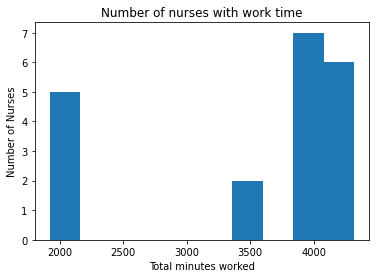

In [ ]:
# Distribution of work duration among nurses
nurse_work_time_1 = []
for v in instance.component_objects(pyo.Constraint, active = True):
  if v.name == "working_time_rule_con":
    for index in v:
      nurse_work_time_1.append(pyo.value(v[index]))

plt.hist(nurse_work_time_1, align = 'mid')
plt.title('Number of nurses who will work X minutes')
plt.xlabel('Total minutes worked')
plt.ylabel('Number of Nurses')
plt.show()


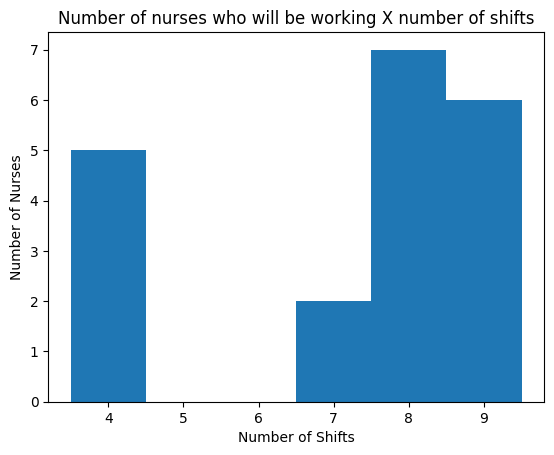

In [ ]:
# Number of nurses that will be working X number of shifts
nurse_shifts_1 = {}
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'x':
    for index in v:
      nurse_shifts_1[index] = pyo.value(v[index])

nurse_shifts_1 = pd.DataFrame.from_dict(nurse_shifts_1, orient = 'index', columns = ['Shifts'])
nurse_shifts_1['Nurse'], nurse_shifts_1['Day'], nurse_shifts_1['Shift'] = nurse_shifts_1.index.str[0], nurse_shifts_1.index.str[1], nurse_shifts_1.index.str[2]
nurse_shifts_1 = nurse_shifts_1.reset_index()
nurse_shifts_1 = nurse_shifts_1.drop('index', axis = 1)
nurse_shifts_1 = nurse_shifts_1.dropna()
nurse_shifts_1 = nurse_shifts_1.pivot(index = ['Nurse'], values = 'Shifts', columns = ['Shift', 'Day'])
nurse_shifts_1['Shifts'] = nurse_shifts_1[list(nurse_shifts_1.columns)].sum(axis = 1)

plt.style.use('default')
plt.hist(nurse_shifts_1['Shifts'],bins = [4,5,6,7,8,9,10], align='left')
plt.title('Number of nurses who will be working X number of shifts')
plt.xlabel('Number of Shifts')
plt.ylabel('Number of Nurses')
plt.show()



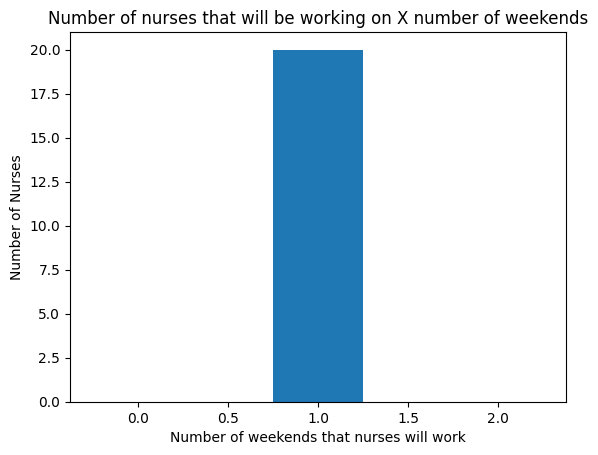

In [ ]:
# Number of nurses that will be working on X number of weekends
nurse_weekend_1 = {}
for v in instance.component_objects(pyo.Var, active=True):
  if v.name == 'w':
    for index in v:
      nurse_weekend_1[index] = pyo.value(v[index])

nurse_weekend_1 = pd.DataFrame.from_dict(nurse_weekend_1, orient = 'index', columns = ['solution'])
nurse_weekend_1['Nurse'], nurse_weekend_1['Week'] = nurse_weekend_1.index.str[0] , nurse_weekend_1.index.str[1] +1,
nurse_weekend_1  =nurse_weekend_1.reset_index()

nurse_weekend_1 = nurse_weekend_1.drop(['index'], axis = 1)
nurse_weekend_1 = nurse_weekend_1.groupby(['Nurse'])['solution'].sum()

plt.hist(nurse_weekend_1, bins = [0,1,2,3], align = 'left', rwidth = 0.5)
plt.title('Number of nurses that will be working on X number of weekends')
plt.xlabel('Number of weekends that nurses will work')
plt.ylabel('Number of Nurses')
plt.show()

| Nurse   |   solution |
|:--------|-----------:|
| A       |          2 |
| B       |          2 |
| C       |          2 |
| D       |          2 |
| E       |          2 |
| F       |          2 |
| G       |          2 |
| H       |          2 |
| I       |          2 |
| J       |          2 |
| K       |          2 |
| L       |          2 |
| M       |          2 |
| N       |          2 |
| O       |          2 |
| P       |          2 |
| Q       |          2 |
| R       |          2 |
| S       |          2 |
| T       |          2 |


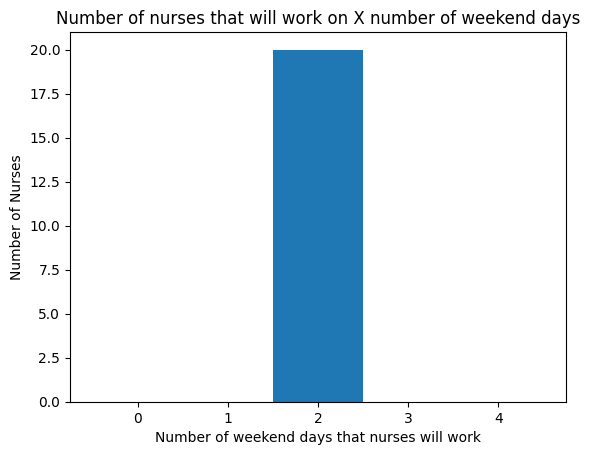

In [ ]:
nurse_weekend__days_1 = {}
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'x':
    for index in v:
      nurse_weekend__days_1[index] = pyo.value(v[index])

nurse_weekend__days_1 = pd.DataFrame.from_dict(nurse_weekend__days_1, orient = 'index', columns = ['solution'])
nurse_weekend__days_1['Nurse'], nurse_weekend__days_1['Day'], nurse_weekend__days_1['Shift'] = nurse_weekend__days_1.index.str[0] , nurse_weekend__days_1.index.str[1] +1,nurse_weekend__days_1.index.str[2]
nurse_weekend__days_1 = nurse_weekend__days_1.reset_index()

nurse_weekend__days_1 = nurse_weekend__days_1.drop(['index'], axis = 1)
nurse_weekend__days_1 = nurse_weekend__days_1[(nurse_weekend__days_1.Day == 6) | (nurse_weekend__days_1.Day == 7) | (nurse_weekend__days_1.Day == 13) | (nurse_weekend__days_1.Day == 14)]
nurse_weekend__days_1 = nurse_weekend__days_1.groupby(['Nurse'])['solution'].sum()

print(nurse_weekend__days_1.to_markdown())

plt.hist(nurse_weekend__days_1, align = 'left', bins=[0,1,2,3,4,5])
plt.title('Number of nurses that will work on X number of weekend days')
plt.xlabel('Number of weekend days that nurses will work')
plt.ylabel('Number of Nurses')
plt.show()

In [ ]:
# Nurses' Requests that are not fulfilled.
e = 0
print("Nurses' Requests that are not fulfilled.")
for v in instance.component_objects(pyo.Var, active=True):
  if v.name == 'x':
    for index in v:
      if (instance.pnot[index] * (1-pyo.value(v[index]))) != 0:
        e = e + 1
        print(index, "=", instance.pnot[index] * (1-pyo.value(v[index])))
        

Nurses' Requests that are not fulfilled.
('B', 0, 'D') = 1.0


<function matplotlib.pyplot.show>

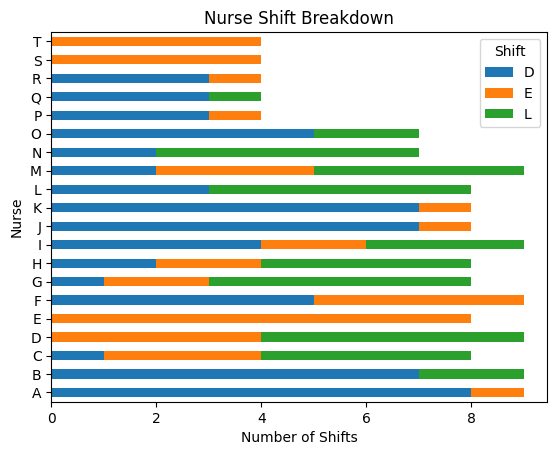

In [ ]:
shift_dist_1 = schedule_1.groupby(['Nurse']).aggregate('sum')
shift_dist_1.plot(kind = "barh", stacked = True, title = 'Nurse Shift Breakdown')
plt.xlabel('Number of Shifts')
plt.show


## Proposed Model 

In [ ]:
# Everything is similar to the original model, except the new constraints and variables
# Model
model = pyo.AbstractModel()

# Sets
# Nurses
model.N = Set()
# Days
model.D = Set()
# Shifts
model.S = Set()
# Weekends
model.W = Set()
# To generate Constraint
model.no_mincs_para = Set()
model.no_mincd_para = Set()

# Total days 
model.days = Param(within = PositiveIntegers)

# Parameters
# maximum number of shifts of type t that can be assigned to employee i.
model.maxs = Param(model.N, model.S, within = NonNegativeReals)
# minimum and maximum number of minutes that employee i must be assigned.
model.minmin = Param(model.N, within=NonNegativeReals)
model.maxmin = Param(model.N, within=NonNegativeReals)
# minimum and maximum number of consecutive shifts that employee i must work. .
model.mincs = Param(model.N, within = NonNegativeReals)
model.maxcs = Param(model.N, within = NonNegativeReals)
# minimum number of consecutive days off that employee i can be assigned.
model.mincd = Param(model.N, within = NonNegativeReals)
# maximum number of weekends that employee i can work.
model.maxwe = Param(model.N, within = PositiveReals)


# penalty if shift type t is not assigned to employee i on day d.
model.pnot = Param(model.N, model.D, model.S, default = 0)
# penalty if shift type t is assigned to employee i on day d.
model.pyes = Param(model.N, model.D, model.S, default = 0)
# preferred total number of employees assigned shift type t on day d.
model.schreq = Param(model.D, model.S, default = 0)
# weight if below the preferred cover for shift type t on day d. 
model.underreq = Param(model.D, model.S, default = 0)
# weight if exceeding the preferred cover for shift type t on day d. 
model.overreq = Param(model.D, model.S, default = 0)
# cannot work in following shift the next day
model.shiftfollow = Param(model.S, model.S, default = 2)

# time for shift t
model.shifttime = Param(model.S, within = NonNegativeReals)
# employees i off day
model.day_off = Param(model.N, model.D, default = 0)

# empty constraint to set constraints after solving
model.c = pyo.ConstraintList()


#Variables

model.w = Var(model.N, model.W, domain = Binary)
model.x = Var(model.N, model.D, model.S, within = Binary)
model.y = Var(model.D, model.S, within = NonNegativeIntegers)
model.z = Var(model.D, model.S, within = NonNegativeIntegers)

# New variables
# additional weekends that employee need to work.
model.addwe = Var(model.N, model.W, within = Binary, initialize = 0)
model.addsh = Var(model.N, model.W, model.S, within = NonNegativeIntegers,initialize = 0)

#Objective

# Minimize the cost of this schedule
def cost_rule(model):
    return (sum(model.pnot[i,j,k]*(1-model.x[i,j,k]) for i in model.N for j in model.D for k in model.S) 
    + sum(model.pyes[i,j,k]*model.x[i,j,k] for i in model.N for j in model.D for k in model.S) 
    + sum(model.underreq[j,k]*model.y[j,k] for j in model.D for k in model.S) 
    + sum(model.overreq[j,k]*model.z[j,k]for j in model.D for k in model.S))


model.cost = Objective(rule=cost_rule, sense = minimize)

#Constraints

# only 1 shift for each day.
def one_shift_day_rule(model, i, j):
    value = sum(model.x[i,j,k] for k in model.S)
    return value <= 1
model.one_shift_day_con = Constraint(model.N, model.D, rule = one_shift_day_rule)

# maximum number of shift that can be taken by that employee
def max_shift_rule(model, i, k):
    return sum(model.x[i,j,k] for j in model.D) <= value(model.maxs[i,k])
model.max_shift_rule_con = Constraint(model.N, model.S, rule = max_shift_rule)

# Modified Constraint
# Total working time rule
def working_time_rule(model, i):
    value = sum(model.shifttime[k]*model.x[i,j,k] for j in model.D for k in model.S)
    value2 = sum(model.shifttime[k]*model.addsh[i,l,k] for l in model.W for k in model.S)
    return inequality(model.minmin[i],value + value2,model.maxmin[i])
model.working_time_rule_con = Constraint(model.N, rule = working_time_rule)

# max consecutive day rule
def max_con_day_rule(model, i, j):
    if j >= value(model.days)- value(model.maxcs[i]):
      return Constraint.Skip
    return sum(model.x[i,j+l,k] for l in range(0,model.maxcs[i]+1) for k in model.S) <= model.maxcs[i]
model.max_con_day_rule_con = Constraint(model.N, model.D, rule = max_con_day_rule)

# min consecutive day rule
def min_con_day_rule(model, i, j, n):
    if j >= value(model.days)-n-1 or n >=model.mincs[i]:
      return Constraint.Skip
    return (sum(model.x[i,j+l,k] for k in model.S for l in [0,n+1]) - sum(model.x[i,j+l,k] for l in range(1,n+1) for k in model.S)) >= (1-n)
model.min_con_day_rule_con = Constraint(model.N, model.D, model.no_mincs_para, rule = min_con_day_rule)

# min consecutive day off rule
def min_con_day_off_rule(model, i, j, n):
    if j >= value(model.days)-n-1 or n >=model.mincd[i]:
      return Constraint.Skip
    return (sum(model.x[i,j+l,k] for k in model.S for l in [0,n+1]) - sum(model.x[i,j+l,k] for l in range(1,n+1) for k in model.S)) <= 1
model.min_con_day_off_rule_con = Constraint(model.N, model.D, model.no_mincd_para, rule = min_con_day_off_rule)

# Modified Constraint
# Constraint to determine if a nurse has worked on a particular week
def week_rule(model, i, j, h):
    if (j+1)%7 != 0:
      return Constraint.Skip
    if (j+1)//7 -1 != h:
      return Constraint.Skip
    return  sum(model.x[i,j,k] + model.x[i,(j-1),k] for k in model.S)  - 2*model.w[i, h] -2*model.addwe[i,h] <= 0
model.week_rule_con = Constraint(model.N, model.D, model.W , rule = week_rule)

# Modified Constraint
def week2_rule(model, i, j, h):
    if (j+1)%7 != 0:
      return Constraint.Skip
    if (j+1)//7-1 != h:
      return Constraint.Skip
    return   sum(model.x[i,j,k] + model.x[i,(j-1),k] for k in model.S) - model.w[i, h]-model.addwe[i,h]>= 0
model.week2_rule_con = Constraint(model.N, model.D, model.W , rule = week2_rule)

# Max number of weekends
def max_weekend_rule(model, i):
    return (sum(model.w[i,h] for h in model.W) <= model.maxwe[i])
model.max_weekend_rule_con = Constraint(model.N, rule = max_weekend_rule)

# Days off rule
def days_off_rule(model, i, j):
    if value(model.day_off[i,j]) == 0:
      return Constraint.Skip
    return sum(model.x[i,j,k] for k in model.S) == 0
model.days_off_rule_con = Constraint(model.N, model.D, rule = days_off_rule)

# Schedule Requirement rule
def req_rule(model, j, k):
    return sum(model.x[i,j,k] for i in model.N) - model.z[j,k] + model.y[j,k] == model.schreq[j,k]
model.req_rule_con = Constraint(model.D, model.S, rule = req_rule)

# Cannot work in following shift rule
def following_rule(model, i, j, k, g):
    if model.shiftfollow[k,g] != 1 or j ==(model.days-1):
      return Constraint.Skip
    return model.x[i,j,k] + model.x[i,j+1,g]  <= model.shiftfollow[k,g]
model.following_con = Constraint(model.N, model.D, model.S, model.S, rule = following_rule)

# New constraint
# Count additional shifts
def add_shift_rule(model, i, j, k, h):
    if (j+1)%7 != 0:
      return Constraint.Skip
    if (j+1)//7-1 != h:
      return Constraint.Skip
    return   model.x[i,j,k] + model.x[i,(j-1),k] + 2*model.addwe[i,h] - model.addsh[i, h, k] <= 2
model.add_shift_rule_con = Constraint(model.N, model.D, model.S, model.W , rule = add_shift_rule)


In [ ]:
instance = model.create_instance(data)
instance.pprint()

32 Set Declarations
    D : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   14 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
    N : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   20 : {'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T'}
    S : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'E', 'D', 'L'}
    W : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    add_shift_rule_con_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain  : Size : Members
        None :     4 : N*D*S*W : 1680 : {('A', 0, 'E', 0), ('A', 0, 'E', 1), ('A', 0, 'D', 0), ('A', 0, 'D', 1), ('A', 0, 'L', 0), ('A', 0, 'L', 1), ('A', 1, 'E', 0), ('

In [ ]:
sol = SolverFactory('cbc', executable='/usr/bin/cbc')
instance.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
sol.options['Seconds'] = 23400
result = sol.solve(instance, tee = True)
result.Solver.Status = SolverStatus.warning

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Aug 21 2017 

command line - /usr/bin/cbc -Seconds 23504 -RatioGap 0.01 -printingOptions all -import /tmp/tmpmx4vs_8w.pyomo.lp -stat=1 -solve -solu /tmp/tmpmx4vs_8w.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 23504
ratioGap was changed from 0 to 0.01
Option for printingOptions changed from normal to all
Presolve 1532 (-561) rows, 882 (-243) columns and 9926 (-5089) elements
Statistics for presolved model
Original problem has 1124 integers (920 of which binary)
Presolved problem has 882 integers (678 of which binary)
==== 734 zero objective 8 different
10 variables have objective of -3
15 variables have objective of -2
14 variables have objective of -1
734 variables have objective of 0
42 variables have objective of 1
14 variables have objective of 2
11 variables have objective of 3
42 variables have objective of 100
==== absolute objective values 5 different
734 variables have objective of 0
56 variables

### Evaluate Proposed Model Solution

| Nurse   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | 11   | 12   | 13   | 14   |
|:--------|:----|:----|:----|:----|:----|:----|:----|:----|:----|:-----|:-----|:-----|:-----|:-----|
| A       | 0   | E   | E   | E   | D   | 0   | 0   | 0   | 0   | D    | D    | D    | D    | D    |
| B       | 0   | D   | D   | D   | L   | 0   | 0   | D   | D   | L    | 0    | 0    | D    | L    |
| C       | L   | 0   | 0   | 0   | E   | D   | L   | L   | 0   | 0    | E    | E    | D    | 0    |
| D       | 0   | L   | L   | L   | L   | 0   | 0   | E   | E   | E    | 0    | 0    | E    | E    |
| E       | E   | E   | 0   | 0   | 0   | E   | E   | E   | 0   | 0    | E    | E    | E    | 0    |
| F       | 0   | D   | D   | D   | D   | 0   | 0   | E   | E   | D    | 0    | 0    | D    | D    |
| G       | 0   | D   | L   | L   | 0   | 0   | E   | D   | 0   | 0    | L    | L    | L    | 0    |
| H       | L   | 0   | 0   | E   | D   | L   | L   | 0   | 0   | L    | L    | 0    | 0   

<function matplotlib.pyplot.show>

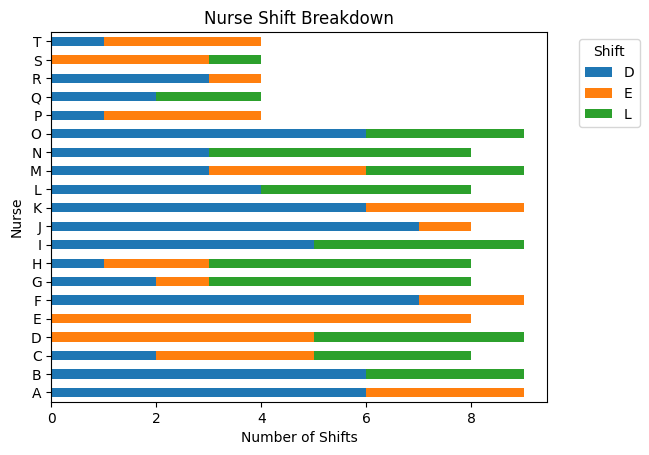

In [ ]:
# Schedule for revised model
schedule_2 = {}
for v in instance.component_objects(pyo.Var, active=True):
  if v.name == 'x':
    for index in v:
      schedule_2[index] = pyo.value(v[index])

schedule_2 = pd.DataFrame.from_dict(schedule_2, orient = 'index', columns = ['solution'])
schedule_2['Nurse'], schedule_2['Day'], schedule_2['Shift'] = schedule_2.index.str[0], schedule_2.index.str[1]+1, schedule_2.index.str[2]
schedule_2 = schedule_2.reset_index()

schedule_2 = schedule_2.drop('index', axis = 1)
schedule_2 = schedule_2.dropna()
schedule_2 = schedule_2.pivot(index = ['Nurse', 'Day'], values = 'solution', columns = 'Shift')

schedule_2['Shift'] = 0
for i in range(len(schedule_2.columns)-1):
  schedule_2['Shift'][(schedule_2.iloc[:,i] == 1)] = schedule_2.columns[i]
schedule_2 = schedule_2['Shift'].reset_index()

schedule_2 = schedule_2.pivot(index = ['Nurse'], values ='Shift', columns = 'Day')

print(schedule_2.to_markdown())

# Shift distribution for each nurse in proposed model
shiftdist_2 = schedule_2.groupby(['Nurse']).aggregate('sum')
shiftdist_2.plot(kind="barh", stacked = True, title = 'Nurse Shift Breakdown')
plt.legend(title = 'Shift', bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.xlabel('Number of Shifts')
plt.show

In [ ]:
# Shifts that are understaffed
understaff_2 = {}
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'y':
    for index in v:
      understaff_2[index] = pyo.value(v[index])

understaff_2 = pd.DataFrame.from_dict(understaff_2, orient = 'index', columns = ['solution'])
understaff_2['Day'], understaff_2['Shift'] = understaff_2.index.str[0]+1 , understaff_2.index.str[1]
understaff_2 = understaff_2.reset_index()

understaff_2 = understaff_2.drop('index', axis = 1)
understaff_2 = understaff_2.pivot(index = ['Day'], values = 'solution', columns = 'Shift')
understaff_2 = understaff_2[(understaff_2.T != 0).any()]

print(understaff_2.to_markdown())

|   Day |   D |   E |   L |
|------:|----:|----:|----:|
|     6 |   2 |   0 |   0 |
|     7 |   0 |   2 |   0 |
|    13 |   0 |   0 |   1 |
|    14 |   0 |   1 |   0 |


In [ ]:
# Nurse requests that are not fulfilled
q = 0
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'x':
    for index in v:
      if (instance.pnot[index] * (1-pyo.value(v[index]))) != 0:
        q = q +1
        print(index, "=", instance.pnot[index] * (1-pyo.value(v[index])))

('B', 0, 'D') = 1.0
('B', 4, 'D') = 1.0
('H', 2, 'E') = 1.0
('N', 3, 'L') = 1.0
('O', 5, 'D') = 1.0
('S', 1, 'E') = 3.0


| Nurse   |   solution |
|:--------|-----------:|
| A       |          2 |
| B       |          2 |
| C       |          3 |
| D       |          2 |
| E       |          3 |
| F       |          2 |
| G       |          2 |
| H       |          3 |
| I       |          2 |
| J       |          3 |
| K       |          1 |
| L       |          3 |
| M       |          2 |
| N       |          3 |
| O       |          1 |
| P       |          2 |
| Q       |          2 |
| R       |          2 |
| S       |          2 |
| T       |          2 |


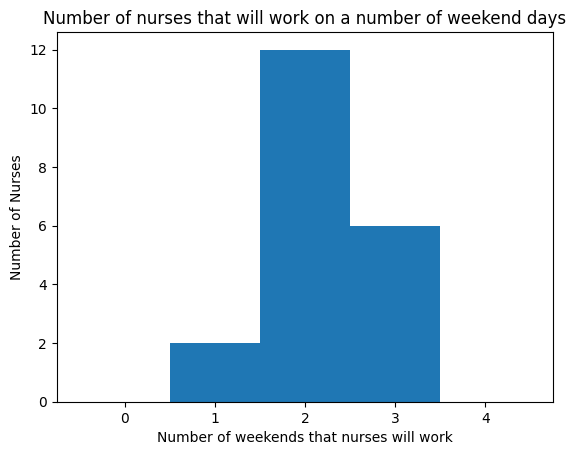

In [ ]:
nurse_weekend__days_2 = {}
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'x':
    for index in v:
      nurse_weekend__days_2[index] = pyo.value(v[index])

nurse_weekend__days_2 = pd.DataFrame.from_dict(nurse_weekend__days_2, orient ='index', columns = ['solution'])
nurse_weekend__days_2['Nurse'], nurse_weekend__days_2['Day'], nurse_weekend__days_2['Shift'] = nurse_weekend__days_2.index.str[0] , nurse_weekend__days_2.index.str[1] +1,nurse_weekend__days_2.index.str[2]
nurse_weekend__days_2 = nurse_weekend__days_2.reset_index()
nurse_weekend__days_2 = nurse_weekend__days_2.drop(['index'], axis = 1)
nurse_weekend__days_2 = nurse_weekend__days_2[(nurse_weekend__days_2.Day == 6) | (nurse_weekend__days_2.Day == 7) | (nurse_weekend__days_2.Day == 13) | (nurse_weekend__days_2.Day == 14)]
nurse_weekend__days_2 = nurse_weekend__days_2.groupby(['Nurse'])['solution'].sum()

print(nurse_weekend__days_2.to_markdown())

plt.hist(nurse_weekend__days_2, align = 'left', bins = [0,1,2,3,4,5])
plt.title('Number of nurses that will work on X number of weekend days')
plt.xlabel('Number of weekend days that nurses will work')
plt.ylabel('Number of Nurses')
plt.show()

In [ ]:
# Nurse number of shifts and additional week breakdown
n = {}
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'x':
    for index in v:
      n[index] = pyo.value(v[index])

n = pd.DataFrame.from_dict(n, orient ='index', columns = ['Shifts'])
n['Nurse'], n['Day'], n['Shift'] = n.index.str[0] , n.index.str[1] +1,n.index.str[2]
n = n.reset_index()

n = n.drop(['index'], axis = 1)
n = pd.DataFrame(n.groupby(['Nurse'], as_index=False)['Shifts'].sum())

m = {}
for v in instance.component_objects(pyo.Var, active=True):
  # print(v.name)
  if v.name == "addwe":
    for index in v:
      m[index] = pyo.value(v[index])

m = pd.DataFrame.from_dict(m, orient = 'index', columns = ['Additional_Weekend'])
m['Nurse'], m['Week'] = m.index.str[0] , m.index.str[1] 
m = m.reset_index()
m = m.drop(['index'], axis = 1)
m=pd.DataFrame(m.groupby(['Nurse'], as_index = False)['Additional_Weekend'].sum())


shift_weekend = n.join(m.set_index('Nurse'), on = 'Nurse')
print(shift_weekend)


   Nurse  Shifts  Additional_Weekend
0      A     9.0                 0.0
1      B     9.0                 0.0
2      C     8.0                 1.0
3      D     9.0                 0.0
4      E     8.0                 1.0
5      F     9.0                 0.0
6      G     8.0                 1.0
7      H     8.0                 1.0
8      I     9.0                 0.0
9      J     8.0                 1.0
10     K     9.0                 0.0
11     L     8.0                 1.0
12     M     9.0                 0.0
13     N     8.0                 1.0
14     O     9.0                 0.0
15     P     4.0                 0.0
16     Q     4.0                 0.0
17     R     4.0                 0.0
18     S     4.0                 0.0
19     T     4.0                 0.0


Objective Value is : 608.0


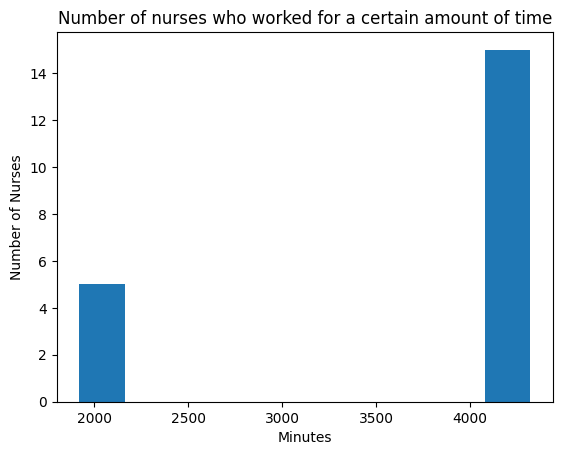

In [ ]:
# Objective Value of proposed model
nurse_work_time_2 = []
for v in instance.component_objects(pyo.Objective, active = True):
  print("Objective Value is :", pyo.value(v))

# Number of nurses who worked for X amount of time
for v in instance.component_objects(pyo.Constraint, active = True):
  if v.name == "working_time_rule_con":
    for index in v:
      nurse_work_time_2.append(pyo.value(v[index]))

plt.hist(nurse_work_time_2)
plt.title('Number of nurses who worked for a certain amount of time')
plt.xlabel('Minutes')
plt.ylabel('Number of Nurses')
plt.show()

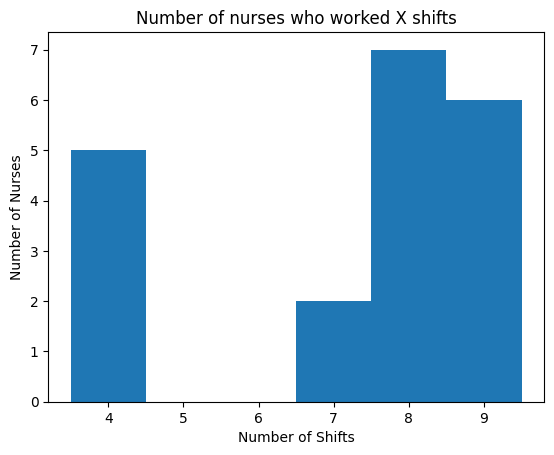

In [ ]:
# Number of nurses that will be working X number of shifts
nurse_shifts_2 = {}
for v in instance.component_objects(pyo.Var, active = True):
  if v.name == 'x':
    for index in v:
      nurse_shifts_2[index] = pyo.value(v[index])

nurse_shifts_2 = pd.DataFrame.from_dict(nurse_shifts_2, orient = 'index', columns = ['Shifts'])
nurse_shifts_2['Nurse'], nurse_shifts_2['Day'], nurse_shifts_2['Shift'] = nurse_shifts_2.index.str[0], nurse_shifts_2.index.str[1], nurse_shifts_2.index.str[2]
nurse_shifts_2 = nurse_shifts_2.reset_index()
nurse_shifts_2 = nurse_shifts_2.drop('index', axis = 1)
nurse_shifts_2 = nurse_shifts_2.dropna()
nurse_shifts_2 = nurse_shifts_2.pivot(index = ['Nurse'], values = 'Shifts', columns = ['Shift', 'Day'])
nurse_shifts_2['Shifts'] = nurse_shifts_2[list(nurse_shifts_2.columns)].sum(axis = 1)

plt.style.use('default')
plt.hist(nurse_shifts_2['Shifts'],bins = [4,5,6,7,8,9,10], align = 'left')
plt.title('Number of nurses who will be working X number of shifts')
plt.xlabel('Number of Shifts')
plt.ylabel('Number of Nurses')
plt.show()
